In [1]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from scipy.special import erf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

plt.rcParams['figure.facecolor'] = 'white'

def EFP(time: np.int32 | npt.NDArray[np.int32], amplitude: np.float64, mu: np.float64, sigma: np.float64, tau: np.float64) -> np.float64 | npt.NDArray[np.float64]:
    Aprime = amplitude * sigma / (tau * np.sqrt(2 / np.pi))
    y1 = -(time - mu) / tau + sigma**2 / (2 * tau**2)
    y2 = (time - mu) / (np.sqrt(2) * sigma) - sigma / (np.sqrt(2) * tau)
    return Aprime * np.exp(y1) * (1 + erf(y2))

def plot_flare(identifier: str):
    dirname = ''
    datafile = f'{dirname}flares/{identifier}.csv'
    df = pd.read_csv(datafile)
    summaryfile = f'{dirname}allflares_preprocessed.csv'
    allcsv = pd.read_csv(summaryfile)
    row = allcsv[allcsv['identifier'] == identifier].iloc[0]

    fig, axs = plt.subplots(2, figsize=(9.6, 9.6), gridspec_kw={'height_ratios': [3, 1]})

    axs[0].set_title(f'{identifier}')
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=.0)
    linestyle = {"elinewidth":1, "capsize":0, "ecolor":"grey"}
    plt.setp(axs[0].get_xticklabels(), visible=False)

    xt = df['Time']
    yt = df['Counts']
    yerr = df['Error']

    axs[0].errorbar(xt, yt, yerr=yerr, fmt='D', ms=3, c='blue', **linestyle)

    for ax in axs:
        ax.tick_params(which='major', width=1)
        ax.tick_params(which='major', length=4)
        ax.margins(x=0)
    axs[0].set_ylabel('Flux (nW/m$^2$)')
    axs[1].set_ylabel('Residual ((o-f)/$\\sigma$)')
    axs[1].set_ylim(bottom=-4,top=4)

    range = (np.max(yt) - np.min(yt))/10
    axs[0].scatter(row['start_time'], \
        row['start_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['start_time'], \
        ymin=row['start_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)
    axs[0].scatter(row['end_time'], \
        row['end_count'], c='k', s=30, zorder=15)
    axs[0].vlines(x=row['end_time'], \
        ymin=row['end_count'] - range, \
        ymax=row['end_count'] + range, color='k', linestyle='dotted', linewidth=2)

    yfit = EFP(xt, row['amplitude'], row['mu'], row['sigma'], row['tau'])
    axs[0].plot(xt, yfit, c='r', zorder=10, lw=3)
    axs[0].tick_params(axis='x', direction='in')
    axs[1].errorbar(xt, (yt-yfit)/np.std(yt-yfit), yerr=yerr/np.std(yt-yfit), fmt='D', ms=3, c='blue', **linestyle)
    axs[1].axhline(np.mean((yt-yfit)/np.std(yt-yfit)), linestyle='--', lw=1, c='navy')

    plt.show()

2024-05-16 15:53:03.867880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 15:53:04.445944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load data

In [2]:
import pandas as pd
from scipy.signal import welch
from tqdm import tqdm

class_info = pd.read_csv('allflares_preprocessed.csv')

data = []
labels = []
ids = []
peak_count = []

tot_flares = 0

for i, iden in enumerate(tqdm(np.array(class_info['identifier']))):
    if class_info['flare_type'][i] != 'A' and class_info['flare_type'][i] != 'B':
        continue

    if bool(class_info['multi_flare_region_flag'][i]): # ignore multi flare regions
        continue

    if class_info['rsquared'][i] < 0.9: # only consider good fits to eliminate incorrect validation dataset
        continue

    #if class_info['identifier'][i] in bad:
    #    continue

    try:
        tod = pd.read_csv('flares/' + iden + '.csv')
    except FileNotFoundError:
        continue

    if np.max(np.diff(tod['Time'])) > 10 or np.max(np.diff(tod['Time'])) < 10:
        continue

    """ Plotting for testing

    if iden in ['20221002h', '20220922c', '20220827r', '20220408w', '20220408j', '20220328y', '20220207a', '20211022e', '20211010a', '20211003d', '20210908u', '20210423h', '20221002x', '20220913c', '20220912r', '20220817d', '20220416p', '20220319a', '20220220c', '20220217d', '20210911d', '20210828g', '20210322r', '20201025a', '20201018a']:

        yfit = EFP(tod['Time'], class_info['amplitude'][i], class_info['mu'][i], class_info['sigma'][i], class_info['tau'][i])
        
        plt.scatter(tod['Time'], tod['Counts'])
        plt.plot(tod['Time'], yfit, c='r') 

        plt.title(iden + ': misclassified, ' + str(class_info['rsquared'][i]))
    
        plt.show()
        
        plt.scatter(tod['Time'], (tod['Counts']-yfit)/np.std(tod['Counts']-yfit))

        plt.title(iden + ': misclassified, ' + str(class_info['rsquared'][i]))
    
        plt.show()

    else:

        if np.random.randint(10) == 5:
            yfit = EFP(tod['Time'], class_info['amplitude'][i], class_info['mu'][i], class_info['sigma'][i], class_info['tau'][i])
            
            plt.scatter(tod['Time'], tod['Counts'])
            plt.plot(tod['Time'], yfit, c='r') 
    
            plt.title(iden + ': classified, ' + str(class_info['rsquared'][i]))
        
            plt.show()
            
            plt.scatter(tod['Time'], (tod['Counts']-yfit)/np.std(tod['Counts']-yfit))
    
            plt.title(iden + ': classified, ' + str(class_info['rsquared'][i]))
        
            plt.show()

    """

    tot_flares += 1
    data.append(list(tod['Counts']))
    peak_count.append(class_info['peak_count'][i])
    
    if class_info['flare_type'][i] == 'A':
        labels.append(0)
    else:
        labels.append(1)

    ids.append(class_info['identifier'][i])

    """
    print(np.array(tod['Counts']))
    
    plt.figure(figsize=(12, 8))

    plt.scatter(np.array(tod['Time']) - np.array(tod['Time'])[0], np.array(tod['Counts']))
    plt.errorbar(np.array(tod['Time']) - np.array(tod['Time'])[0], np.array(tod['Counts']), np.array(tod['Error']), ls='')

    plt.title(class_info['identifier'][i] + ': ' + class_info['flare_type'][i], fontsize=24)

    plt.show()
    """

labels = np.array(labels)

print(tot_flares)

          date identifier  start_time  start_count  peak_time  peak_count  \
0     20221104  20221104q     82785.0         9.56    82965.0      101.03   
1     20221104  20221104a      8135.0         4.08     8455.0       42.79   
2     20221104  20221104p     80175.0        49.67    80575.0      507.60   
3     20221104  20221104o     72505.0        10.25    73475.0      103.02   
4     20221104  20221104n     71875.0         0.00    74915.0       20.66   
...        ...        ...         ...          ...        ...         ...   
8039  20190921  20190921a     15395.0         0.32    15585.0        3.26   
8040  20190917  20190917b     70935.0         0.90    71015.0        7.00   
8041  20190917  20190917a     60615.0         0.25    60895.0        2.45   
8042  20190915  20190915a     65555.0         0.14    66025.0        1.37   
8043  20190914  20190914a     74075.0         0.19    74215.0        2.05   

      end_time  end_count  scpeaks0-05  multi_flare_region_flag  ...  \
0  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8044/8044 [00:00<00:00, 12603.66it/s]

572


# Testing plotting & fitting individually

A


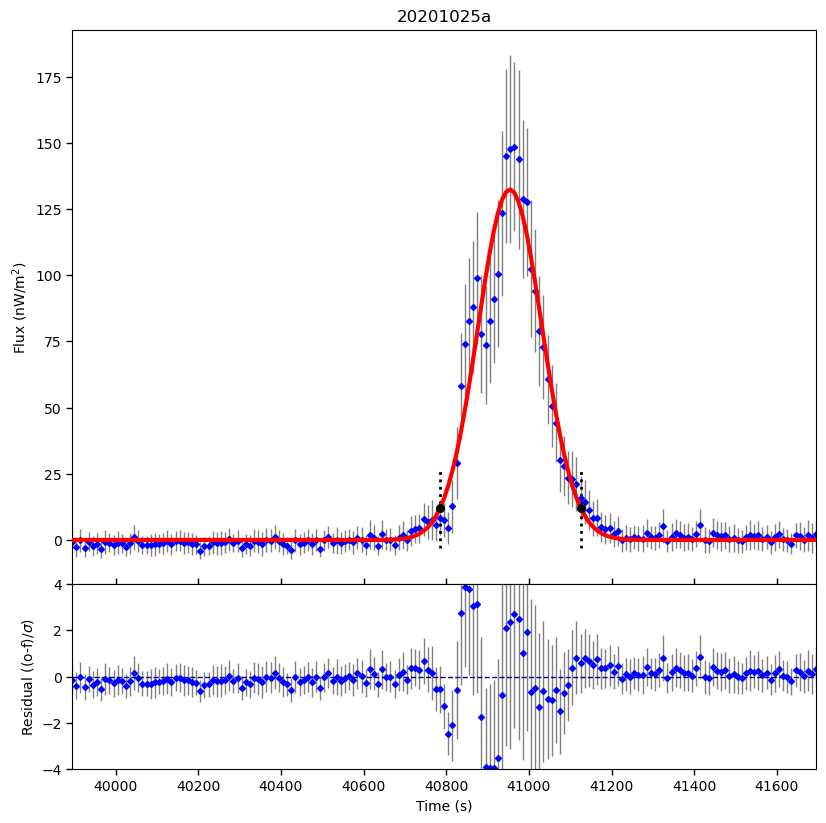

/tmp/ipykernel_1495080/2045769740.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.scatter(np.arange(0, len(data[int(np.argwhere(np.array(ids)==test_id))][data[int(np.argwhere(np.array(ids)==test_id))] != 0]))*10, data[int(np.argwhere(np.array(ids)==test_id))][data[int(np.argwhere(np.array(ids)==test_id))] != 0])


Text(0.5, 1.0, '20201025a')

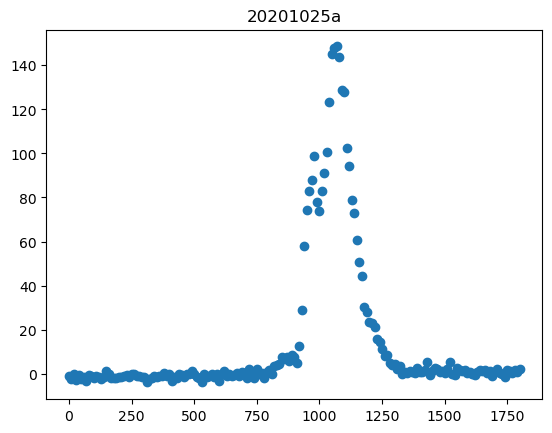

In [11]:
test_id = '20201025a'

print(np.array(class_info['flare_type'])[np.argwhere(np.array(class_info['identifier']) == test_id)[0,0]])

plot_flare(test_id)

plt.scatter(np.arange(0, len(data[int(np.argwhere(np.array(ids)==test_id))][data[int(np.argwhere(np.array(ids)==test_id))] != 0]))*10, data[int(np.argwhere(np.array(ids)==test_id))][data[int(np.argwhere(np.array(ids)==test_id))] != 0])

plt.title(test_id)

# Pad arrays for training

In [3]:
data = pad_sequences(data, padding='post', dtype=float)

print(data[0])
print(data.shape)
print(type(data[0, 0]))

#print(labels)

#for d in data:
#    plt.scatter(range(len(d)), d)
#    
#    plt.show()

[5.58495088 4.38837255 3.31846078 ... 0.         0.         0.        ]
(572, 2089)
<class 'numpy.float64'>


# Individual training

In [52]:
model = Sequential()
    
# First convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data[0]), 1)))
model.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model.fit(data, labels, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7305 - loss: 4.3398 - val_accuracy: 0.8273 - val_loss: 0.4977
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8030 - loss: 0.5291 - val_accuracy: 0.8273 - val_loss: 0.4704
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7963 - loss: 0.5082 - val_accuracy: 0.8273 - val_loss: 0.4543
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7897 - loss: 0.4975 - val_accuracy: 0.8273 - val_loss: 0.4625
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8024 - loss: 0.4742 - val_accuracy: 0.8273 - val_loss: 0.4854
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8114 - loss: 0.4545 - val_accuracy: 0.8259 - val_loss: 0.4540
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8155 - loss: 0.4569 - val_accuracy: 0.8273 - val_loss: 0.4483
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8038 - loss: 0.4506 - val_accuracy: 0.8300 - 

In [54]:
print(np.expand_dims(data, axis=-1).shape)

preds = model.predict(np.expand_dims(data, axis=-1))

print(preds)

(3704, 2089, 1)
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[9.9622744e-01]
 [1.9336412e-07]
 [1.0000000e+00]
 ...
 [9.9951065e-01]
 [8.2865191e-01]
 [9.9999917e-01]]


In [58]:
class_list = {'0': 'A', '1': 'B'}

num_high = 0
num_mis_high = 0
num_mis_low = 0

tot_exc = 0

for i, pred in enumerate(tqdm(preds)):
    conf = np.abs(pred[0]-0.5)+0.5
    pred_class = int(np.round(pred[0]))

    #plt.scatter(np.arange(0, len(data[i][data[i] != 0]))*10, data[i][data[i] != 0])

    #plt.xlabel('Time')
    #plt.ylabel('Count')

    #plt.title(f"{ids[i]}, Pred. Class: {class_list[str(pred_class)]}, Actual Class: {class_list[str(labels[i])]}, Conf = {np.round(conf, 3)}")

    if peak_count[i] < 10:
        #plt.close()
        continue

    tot_exc += 1
    
    if conf > 0.9:
        #plt.savefig(f'classifications/high_confidence/{ids[i]}.png')
        num_high += 1

        if class_list[str(pred_class)] != class_list[str(labels[i])]:
            num_mis_high += 1
            #plt.show()
    else:
        #plt.savefig(f'classifications/low_confidence/{ids[i]}.png')

        if class_list[str(pred_class)] != class_list[str(labels[i])]:
            num_mis_low += 1
            #plt.show()

    #plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3704/3704 [00:00<00:00, 122831.29it/s]


In [34]:
# cutoff = 0.8

print(f'Number of high confidence classifications = {num_high}')
print(f'Number of low confidence classifications = {len(preds) - num_high}')
print(f'Percentage of high confidence = {num_high/len(preds)}')

print(f'Total misclassified = {num_mis_high + num_mis_low}')
print(f'Accuracy in total = {1-(num_mis_high + num_mis_low)/len(preds)}')

print(f'Accuracy of high confidence = {1-num_mis_high/num_high}')
print(f'Accuracy of low confidence = {1-num_mis_low/(len(preds) - num_high)}')

Number of high confidence classifications = 3637
Number of low confidence classifications = 67
Percentage of high confidence = 0.9819114470842333
Total misclassified = 160
Accuracy in total = 0.9568034557235421
Accuracy of high confidence = 0.963706351388507
Accuracy of low confidence = 0.582089552238806


In [60]:
# cutoff = 0.9

print(f'tot = {tot_exc}')

print(f'Number of high confidence classifications = {num_high}')
print(f'Number of low confidence classifications = {tot_exc - num_high}')
print(f'Percentage of high confidence = {num_high/tot_exc}')

print(f'Total misclassified = {num_mis_high + num_mis_low}')
print(f'Accuracy in total = {1-(num_mis_high + num_mis_low)/tot_exc}')

print(f'Accuracy of high confidence = {1-num_mis_high/num_high}')
print(f'Accuracy of low confidence = {1-num_mis_low/(tot_exc - num_high)}')

tot = 3159
Number of high confidence classifications = 3071
Number of low confidence classifications = 88
Percentage of high confidence = 0.9721430832541944
Total misclassified = 85
Accuracy in total = 0.9730927508705286
Accuracy of high confidence = 0.982090524259199
Accuracy of low confidence = 0.6590909090909092


# 20 iterations of k=2 fold validation

In [4]:
from sklearn.model_selection import KFold
from keras.layers import LSTM, Dense, Dropout, Bidirectional
import json
import gc

n_trials = 20

check = {}

acc = []
high_conf_acc = []
low_conf_acc = []

for n in range(n_trials):
    print(f'ITERATION {n+1}')

    kf = KFold(n_splits=2, shuffle=True)#, random_state=42) # shuffle folds each time
    
    for train_ind, val_ind in kf.split(data):
        data_train, data_val = data[train_ind], data[val_ind]
        labels_train, labels_val = labels[train_ind], labels[val_ind]
        ids_train, ids_val = np.array(ids)[train_ind], np.array(ids)[val_ind]
    
        
        model = Sequential()
        
        # First convolutional layer
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data_train[0]), 1)))
        model.add(MaxPooling1D(pool_size=2))
        
        # Second convolutional layer
        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        
        # Third convolutional layer
        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        
        # Flatten the output
        model.add(Flatten())
        
        # Fully connected layer
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        
        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
        model.fit(data_train, labels_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    
        preds = model.predict(np.expand_dims(data_val, axis=-1))

        # Delete the model and call garbage collector
        del model
        gc.collect()
        
        # Clear the session to free memory
        tf.keras.backend.clear_session()
        
        class_list = {'0': 'A', '1': 'B'}
        
        num_high = 0
        num_mis_high = 0
        num_mis_low = 0
        
        tot_exc = 0
        
        for i, pred in enumerate(tqdm(preds)):
            conf = np.abs(pred[0]-0.5)/0.5
            pred_class = int(np.round(pred[0]))

            # ignore plotting for now
            #plt.scatter(np.arange(0, len(data[i][data[i] != 0]))*10, data[i][data[i] != 0])
        
            #plt.xlabel('Time')
            #plt.ylabel('Count')
        
            #plt.title(f"{ids[i]}, Pred. Class: {class_list[str(pred_class)]}, Actual Class: {class_list[str(labels[i])]}, Conf = {np.round(conf, 3)}")
        
            if peak_count[i] < 10: # ignore low-SNR flares
                #plt.close()
                continue
        
            tot_exc += 1
            
            if conf > 0.9: # split by confidence levels, more easily identify initially incorrect classifications
                #plt.savefig(f'classifications/high_confidence/{ids[i]}.png')
                num_high += 1
        
                if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
                    if ids_val[i] not in check.keys():
                        check[ids_val[i]] = {'high_conf_mis': 0, 'low_conf_mis': 0, 'low_conf_cor': 0}
                    
                    check[ids_val[i]]['high_conf_mis'] += 1
                    
                    num_mis_high += 1
    
                    #plt.scatter(np.arange(0, len(data_val[i][data_val[i] != 0]))*10, data_val[i][data_val[i] != 0])
        
                    #plt.xlabel('Time')
                    #plt.ylabel('Count')
                
                    #plt.title(f"{ids_val[i]}, Pred. Class: {class_list[str(pred_class)]}, Actual Class: {class_list[str(labels_val[i])]}, Conf = {np.round(conf, 3)}")
                    
                    #plt.show()
            else:
                #plt.savefig(f'classifications/low_confidence/{ids[i]}.png')
        
                if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
                    if ids_val[i] not in check.keys():
                        check[ids_val[i]] = {'high_conf_mis': 0, 'low_conf_mis': 0, 'low_conf_cor': 0}
                    
                    check[ids_val[i]]['low_conf_mis'] += 1
                    
                    num_mis_low += 1
    
                    #plt.scatter(np.arange(0, len(data_val[i][data_val[i] != 0]))*10, data_val[i][data_val[i] != 0])
        
                    #plt.xlabel('Time')
                    #plt.ylabel('Count')
                
                    #plt.title(f"{ids_val[i]}, Pred. Class: {class_list[str(pred_class)]}, Actual Class: {class_list[str(labels_val[i])]}, Conf = {np.round(conf, 3)}")
                    
                    #plt.show()
                else:
                    if ids_val[i] not in check.keys():
                        check[ids_val[i]] = {'high_conf_mis': 0, 'low_conf_mis': 0, 'low_conf_cor': 0}
                    
                    check[ids_val[i]]['low_conf_cor'] += 1
        
            #plt.close()
    
        print(f'Number of high confidence classifications = {num_high}')
        print(f'Number of low confidence classifications = {tot_exc - num_high}')
        print(f'Percentage of high confidence = {num_high/tot_exc}')
        
        print(f'Total misclassified = {num_mis_high + num_mis_low}')
        print(f'Accuracy in total = {1-(num_mis_high + num_mis_low)/tot_exc}')
        
        print(f'Accuracy of high confidence = {1-num_mis_high/num_high}')
    
        acc.append(1-(num_mis_high + num_mis_low)/tot_exc)
        high_conf_acc.append(1-num_mis_high/num_high)

        try:
            print(f'Accuracy of low confidence = {1-num_mis_low/(tot_exc - num_high)}')
            low_conf_acc.append(1-num_mis_low/(tot_exc - num_high))
        except ZeroDivisionError:
            low_conf_acc.append(None)

#with open('problem_ids.json', 'w') as f:
#    json.dump(check, f)

ITERATION 1


/home/mrchu/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-16 15:53:15.018402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-16 15:53:15.039018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testin

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 165116.44it/s]


Number of high confidence classifications = 281
Number of low confidence classifications = 5
Percentage of high confidence = 0.9825174825174825
Total misclassified = 24
Accuracy in total = 0.916083916083916
Accuracy of high confidence = 0.9145907473309609
Accuracy of low confidence = 1.0
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 155264.17it/s]


Number of high confidence classifications = 280
Number of low confidence classifications = 6
Percentage of high confidence = 0.9790209790209791
Total misclassified = 27
Accuracy in total = 0.9055944055944056
Accuracy of high confidence = 0.9178571428571428
Accuracy of low confidence = 0.33333333333333337
ITERATION 2
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 173976.93it/s]


Number of high confidence classifications = 277
Number of low confidence classifications = 9
Percentage of high confidence = 0.9685314685314685
Total misclassified = 22
Accuracy in total = 0.9230769230769231
Accuracy of high confidence = 0.927797833935018
Accuracy of low confidence = 0.7777777777777778
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 128447.47it/s]


Number of high confidence classifications = 273
Number of low confidence classifications = 13
Percentage of high confidence = 0.9545454545454546
Total misclassified = 32
Accuracy in total = 0.8881118881118881
Accuracy of high confidence = 0.9157509157509157
Accuracy of low confidence = 0.3076923076923077
ITERATION 3
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 179630.27it/s]


Number of high confidence classifications = 283
Number of low confidence classifications = 3
Percentage of high confidence = 0.9895104895104895
Total misclassified = 21
Accuracy in total = 0.9265734265734266
Accuracy of high confidence = 0.9328621908127208
Accuracy of low confidence = 0.33333333333333337
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 181395.88it/s]


Number of high confidence classifications = 284
Number of low confidence classifications = 2
Percentage of high confidence = 0.993006993006993
Total misclassified = 22
Accuracy in total = 0.9230769230769231
Accuracy of high confidence = 0.9225352112676056
Accuracy of low confidence = 1.0
ITERATION 4
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 175273.37it/s]


Number of high confidence classifications = 273
Number of low confidence classifications = 13
Percentage of high confidence = 0.9545454545454546
Total misclassified = 18
Accuracy in total = 0.9370629370629371
Accuracy of high confidence = 0.9413919413919414
Accuracy of low confidence = 0.8461538461538461
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 174737.21it/s]


Number of high confidence classifications = 276
Number of low confidence classifications = 10
Percentage of high confidence = 0.965034965034965
Total misclassified = 21
Accuracy in total = 0.9265734265734266
Accuracy of high confidence = 0.9311594202898551
Accuracy of low confidence = 0.8
ITERATION 5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 172600.14it/s]


Number of high confidence classifications = 272
Number of low confidence classifications = 14
Percentage of high confidence = 0.951048951048951
Total misclassified = 25
Accuracy in total = 0.9125874125874126
Accuracy of high confidence = 0.9264705882352942
Accuracy of low confidence = 0.6428571428571428
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 181204.07it/s]


Number of high confidence classifications = 280
Number of low confidence classifications = 6
Percentage of high confidence = 0.9790209790209791
Total misclassified = 28
Accuracy in total = 0.9020979020979021
Accuracy of high confidence = 0.9035714285714286
Accuracy of low confidence = 0.8333333333333334
ITERATION 6
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 183729.66it/s]


Number of high confidence classifications = 278
Number of low confidence classifications = 8
Percentage of high confidence = 0.972027972027972
Total misclassified = 20
Accuracy in total = 0.9300699300699301
Accuracy of high confidence = 0.935251798561151
Accuracy of low confidence = 0.75
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 168124.87it/s]


Number of high confidence classifications = 279
Number of low confidence classifications = 7
Percentage of high confidence = 0.9755244755244755
Total misclassified = 26
Accuracy in total = 0.9090909090909091
Accuracy of high confidence = 0.9139784946236559
Accuracy of low confidence = 0.7142857142857143
ITERATION 7
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 172080.18it/s]


Number of high confidence classifications = 278
Number of low confidence classifications = 8
Percentage of high confidence = 0.972027972027972
Total misclassified = 36
Accuracy in total = 0.8741258741258742
Accuracy of high confidence = 0.8812949640287769
Accuracy of low confidence = 0.625
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 181725.64it/s]


Number of high confidence classifications = 271
Number of low confidence classifications = 15
Percentage of high confidence = 0.9475524475524476
Total misclassified = 23
Accuracy in total = 0.9195804195804196
Accuracy of high confidence = 0.9372693726937269
Accuracy of low confidence = 0.6
ITERATION 8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 180549.51it/s]


Number of high confidence classifications = 265
Number of low confidence classifications = 21
Percentage of high confidence = 0.9265734265734266
Total misclassified = 30
Accuracy in total = 0.8951048951048951
Accuracy of high confidence = 0.9132075471698113
Accuracy of low confidence = 0.6666666666666667
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 178507.58it/s]


Number of high confidence classifications = 284
Number of low confidence classifications = 2
Percentage of high confidence = 0.993006993006993
Total misclassified = 29
Accuracy in total = 0.8986013986013986
Accuracy of high confidence = 0.9014084507042254
Accuracy of low confidence = 0.5
ITERATION 9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 179737.93it/s]


Number of high confidence classifications = 281
Number of low confidence classifications = 5
Percentage of high confidence = 0.9825174825174825
Total misclassified = 21
Accuracy in total = 0.9265734265734266
Accuracy of high confidence = 0.9288256227758007
Accuracy of low confidence = 0.8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 170563.19it/s]


Number of high confidence classifications = 276
Number of low confidence classifications = 10
Percentage of high confidence = 0.965034965034965
Total misclassified = 24
Accuracy in total = 0.916083916083916
Accuracy of high confidence = 0.9239130434782609
Accuracy of low confidence = 0.7
ITERATION 10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 171147.23it/s]


Number of high confidence classifications = 276
Number of low confidence classifications = 10
Percentage of high confidence = 0.965034965034965
Total misclassified = 18
Accuracy in total = 0.9370629370629371
Accuracy of high confidence = 0.9492753623188406
Accuracy of low confidence = 0.6
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 121685.02it/s]


Number of high confidence classifications = 284
Number of low confidence classifications = 2
Percentage of high confidence = 0.993006993006993
Total misclassified = 27
Accuracy in total = 0.9055944055944056
Accuracy of high confidence = 0.9084507042253521
Accuracy of low confidence = 0.5
ITERATION 11
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 172898.67it/s]


Number of high confidence classifications = 267
Number of low confidence classifications = 19
Percentage of high confidence = 0.9335664335664335
Total misclassified = 26
Accuracy in total = 0.9090909090909091
Accuracy of high confidence = 0.9213483146067416
Accuracy of low confidence = 0.736842105263158
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 177189.21it/s]


Number of high confidence classifications = 280
Number of low confidence classifications = 6
Percentage of high confidence = 0.9790209790209791
Total misclassified = 24
Accuracy in total = 0.916083916083916
Accuracy of high confidence = 0.9178571428571428
Accuracy of low confidence = 0.8333333333333334
ITERATION 12
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 181533.13it/s]


Number of high confidence classifications = 281
Number of low confidence classifications = 5
Percentage of high confidence = 0.9825174825174825
Total misclassified = 21
Accuracy in total = 0.9265734265734266
Accuracy of high confidence = 0.9323843416370107
Accuracy of low confidence = 0.6
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 177766.89it/s]


Number of high confidence classifications = 281
Number of low confidence classifications = 5
Percentage of high confidence = 0.9825174825174825
Total misclassified = 28
Accuracy in total = 0.9020979020979021
Accuracy of high confidence = 0.9110320284697508
Accuracy of low confidence = 0.4
ITERATION 13
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 178348.34it/s]


Number of high confidence classifications = 271
Number of low confidence classifications = 15
Percentage of high confidence = 0.9475524475524476
Total misclassified = 30
Accuracy in total = 0.8951048951048951
Accuracy of high confidence = 0.9003690036900369
Accuracy of low confidence = 0.8
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 162543.49it/s]


Number of high confidence classifications = 284
Number of low confidence classifications = 2
Percentage of high confidence = 0.993006993006993
Total misclassified = 30
Accuracy in total = 0.8951048951048951
Accuracy of high confidence = 0.9014084507042254
Accuracy of low confidence = 0.0
ITERATION 14
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 176511.32it/s]


Number of high confidence classifications = 282
Number of low confidence classifications = 4
Percentage of high confidence = 0.986013986013986
Total misclassified = 23
Accuracy in total = 0.9195804195804196
Accuracy of high confidence = 0.9219858156028369
Accuracy of low confidence = 0.75
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 178853.58it/s]


Number of high confidence classifications = 281
Number of low confidence classifications = 5
Percentage of high confidence = 0.9825174825174825
Total misclassified = 29
Accuracy in total = 0.8986013986013986
Accuracy of high confidence = 0.9074733096085409
Accuracy of low confidence = 0.4
ITERATION 15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 171956.84it/s]


Number of high confidence classifications = 285
Number of low confidence classifications = 1
Percentage of high confidence = 0.9965034965034965
Total misclassified = 35
Accuracy in total = 0.8776223776223776
Accuracy of high confidence = 0.8807017543859649
Accuracy of low confidence = 0.0
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 176980.07it/s]


Number of high confidence classifications = 277
Number of low confidence classifications = 9
Percentage of high confidence = 0.9685314685314685
Total misclassified = 16
Accuracy in total = 0.9440559440559441
Accuracy of high confidence = 0.9494584837545126
Accuracy of low confidence = 0.7777777777777778
ITERATION 16
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 180985.36it/s]


Number of high confidence classifications = 283
Number of low confidence classifications = 3
Percentage of high confidence = 0.9895104895104895
Total misclassified = 21
Accuracy in total = 0.9265734265734266
Accuracy of high confidence = 0.9328621908127208
Accuracy of low confidence = 0.33333333333333337
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 173976.93it/s]


Number of high confidence classifications = 284
Number of low confidence classifications = 2
Percentage of high confidence = 0.993006993006993
Total misclassified = 20
Accuracy in total = 0.9300699300699301
Accuracy of high confidence = 0.9295774647887324
Accuracy of low confidence = 1.0
ITERATION 17
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 169383.08it/s]


Number of high confidence classifications = 271
Number of low confidence classifications = 15
Percentage of high confidence = 0.9475524475524476
Total misclassified = 27
Accuracy in total = 0.9055944055944056
Accuracy of high confidence = 0.9188191881918819
Accuracy of low confidence = 0.6666666666666667
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 174992.11it/s]


Number of high confidence classifications = 280
Number of low confidence classifications = 6
Percentage of high confidence = 0.9790209790209791
Total misclassified = 18
Accuracy in total = 0.9370629370629371
Accuracy of high confidence = 0.9392857142857143
Accuracy of low confidence = 0.8333333333333334
ITERATION 18
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 174204.32it/s]


Number of high confidence classifications = 279
Number of low confidence classifications = 7
Percentage of high confidence = 0.9755244755244755
Total misclassified = 22
Accuracy in total = 0.9230769230769231
Accuracy of high confidence = 0.931899641577061
Accuracy of low confidence = 0.5714285714285714
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 179495.88it/s]


Number of high confidence classifications = 282
Number of low confidence classifications = 4
Percentage of high confidence = 0.986013986013986
Total misclassified = 21
Accuracy in total = 0.9265734265734266
Accuracy of high confidence = 0.9290780141843972
Accuracy of low confidence = 0.75
ITERATION 19
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 164437.42it/s]


Number of high confidence classifications = 278
Number of low confidence classifications = 8
Percentage of high confidence = 0.972027972027972
Total misclassified = 25
Accuracy in total = 0.9125874125874126
Accuracy of high confidence = 0.9172661870503597
Accuracy of low confidence = 0.75
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 175427.16it/s]


Number of high confidence classifications = 274
Number of low confidence classifications = 12
Percentage of high confidence = 0.958041958041958
Total misclassified = 20
Accuracy in total = 0.9300699300699301
Accuracy of high confidence = 0.9452554744525548
Accuracy of low confidence = 0.5833333333333333
ITERATION 20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 177819.59it/s]


Number of high confidence classifications = 283
Number of low confidence classifications = 3
Percentage of high confidence = 0.9895104895104895
Total misclassified = 27
Accuracy in total = 0.9055944055944056
Accuracy of high confidence = 0.911660777385159
Accuracy of low confidence = 0.33333333333333337
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 175606.93it/s]

Number of high confidence classifications = 280
Number of low confidence classifications = 6
Percentage of high confidence = 0.9790209790209791
Total misclassified = 15
Accuracy in total = 0.9475524475524475
Accuracy of high confidence = 0.9535714285714285
Accuracy of low confidence = 0.6666666666666667


# Check stats

In [13]:
print(acc)

print(np.mean(acc))
print(np.std(acc))

[0.916083916083916, 0.9055944055944056, 0.9230769230769231, 0.8881118881118881, 0.9265734265734266, 0.9230769230769231, 0.9370629370629371, 0.9265734265734266, 0.9125874125874126, 0.9020979020979021, 0.9300699300699301, 0.9090909090909091, 0.8741258741258742, 0.9195804195804196, 0.8951048951048951, 0.8986013986013986, 0.9265734265734266, 0.916083916083916, 0.9370629370629371, 0.9055944055944056, 0.9090909090909091, 0.916083916083916, 0.9265734265734266, 0.9020979020979021, 0.8951048951048951, 0.8951048951048951, 0.9195804195804196, 0.8986013986013986, 0.8776223776223776, 0.9440559440559441, 0.9265734265734266, 0.9300699300699301, 0.9055944055944056, 0.9370629370629371, 0.9230769230769231, 0.9265734265734266, 0.9125874125874126, 0.9300699300699301, 0.9055944055944056, 0.9475524475524475]
0.915034965034965
0.016863154617884603


In [5]:
bad = []

for id in check.keys():
    if check[id]['high_conf_mis'] >= 15:
        print(f"{id}: misclassified {check[id]['high_conf_mis']} times with high confidence")
        bad.append(id)
    #if check[id]['low_conf_mis'] >= 10:
    #    print(f"{id}: misclassified {check[id]['low_conf_mis']} with low confidence")
    #if check[id]['low_conf_cor'] >= 10:
    #    print(f"{id}: correctly classified {check[id]['low_conf_cor']} with low confidence")

print(len(bad))

20221020h: misclassified 17 times with high confidence
20220922c: misclassified 20 times with high confidence
20220913c: misclassified 17 times with high confidence
20220912r: misclassified 20 times with high confidence
20220827r: misclassified 20 times with high confidence
20220817d: misclassified 20 times with high confidence
20220416p: misclassified 19 times with high confidence
20220319a: misclassified 20 times with high confidence
20220220c: misclassified 18 times with high confidence
20220217d: misclassified 18 times with high confidence
20211010a: misclassified 19 times with high confidence
20210911d: misclassified 20 times with high confidence
20210908u: misclassified 20 times with high confidence
20210322r: misclassified 20 times with high confidence
20210224d: misclassified 17 times with high confidence
20221003q: misclassified 16 times with high confidence
20221002x: misclassified 20 times with high confidence
20221002h: misclassified 20 times with high confidence
20220408j:

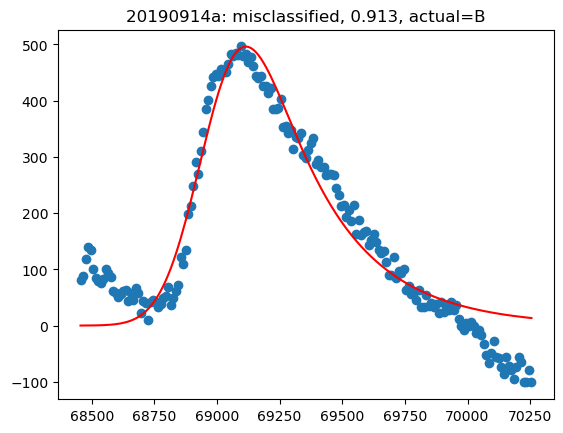

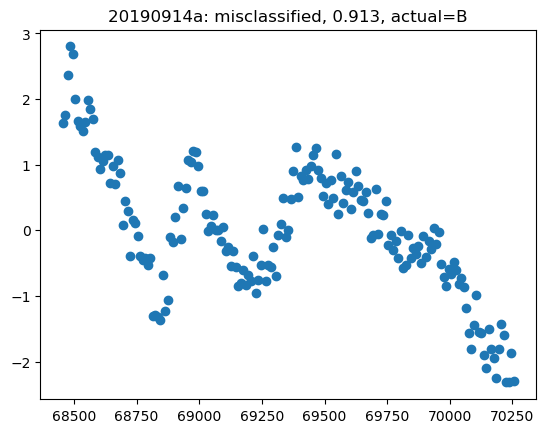

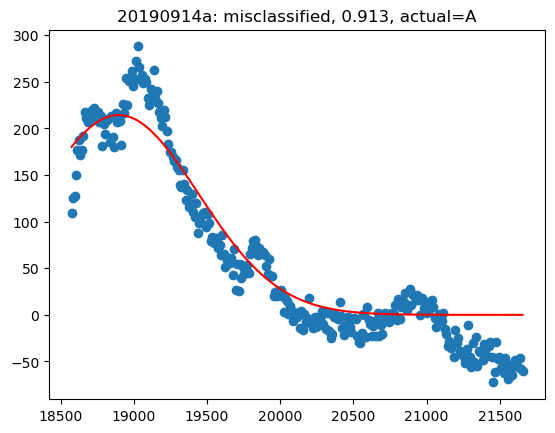

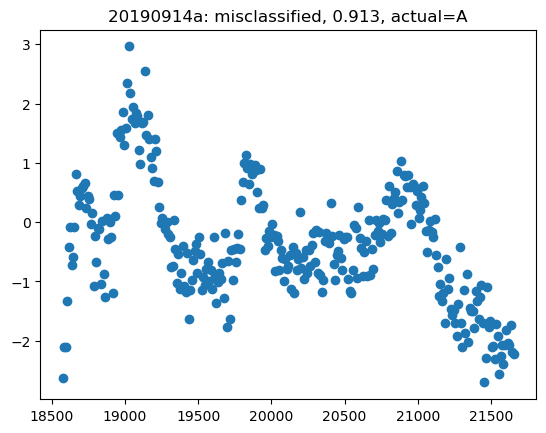

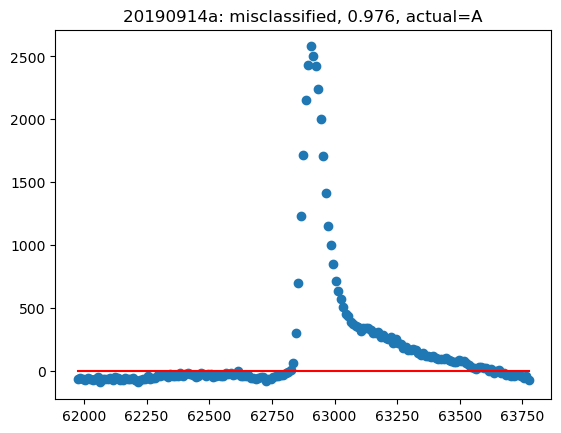

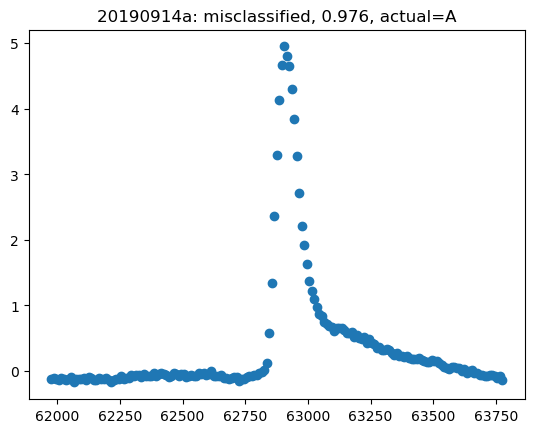

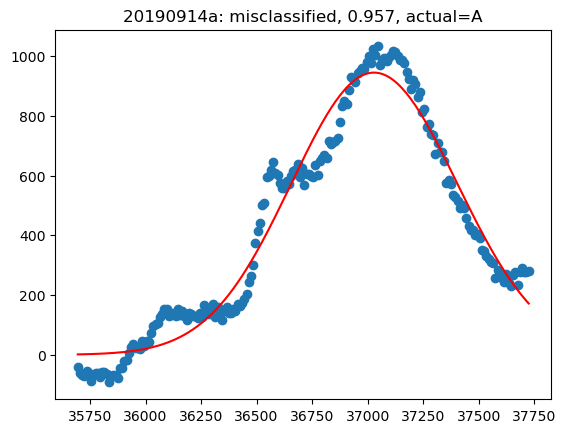

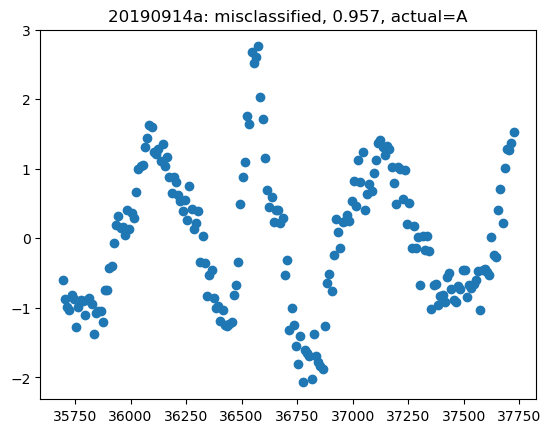

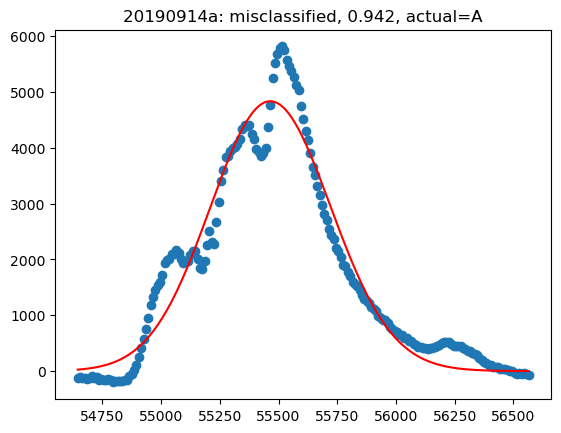

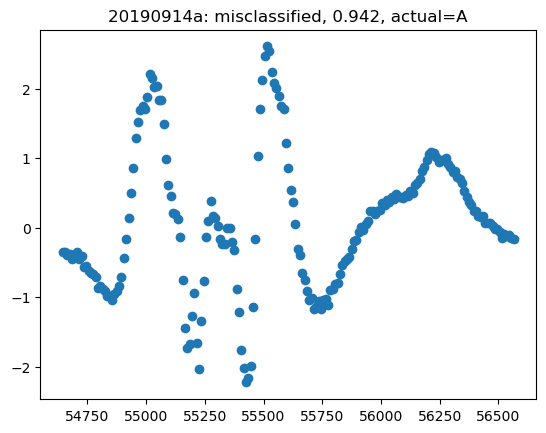

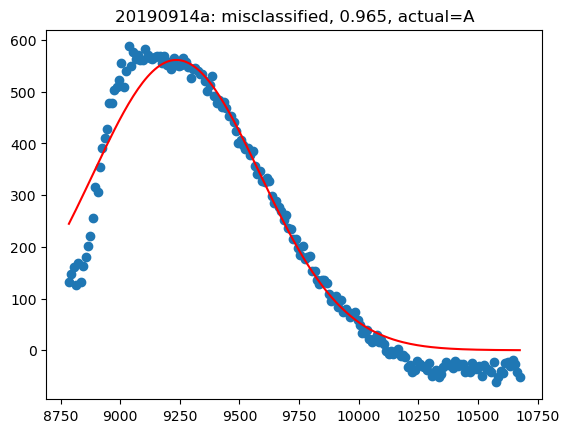

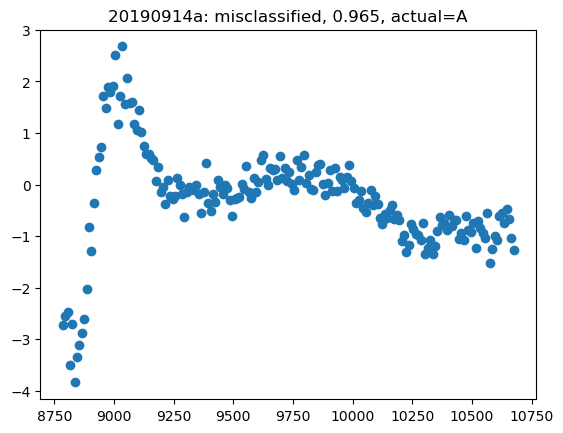

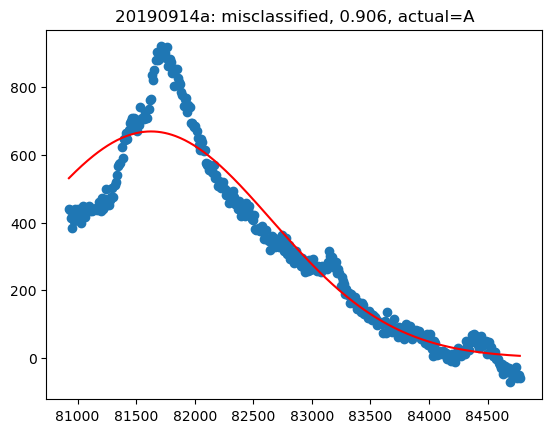

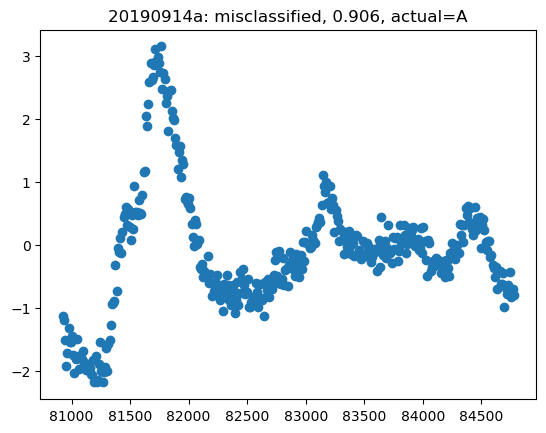

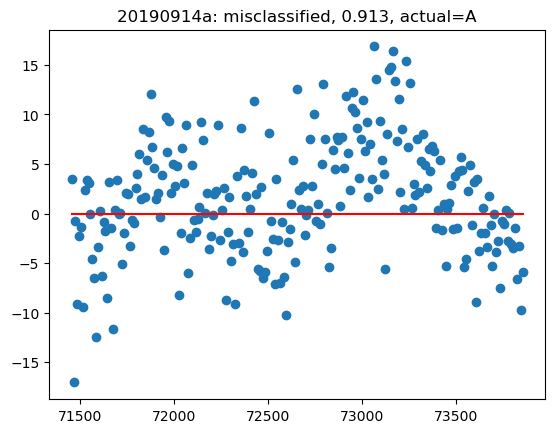

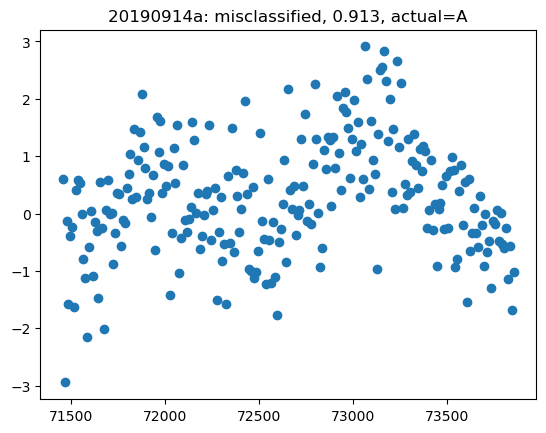

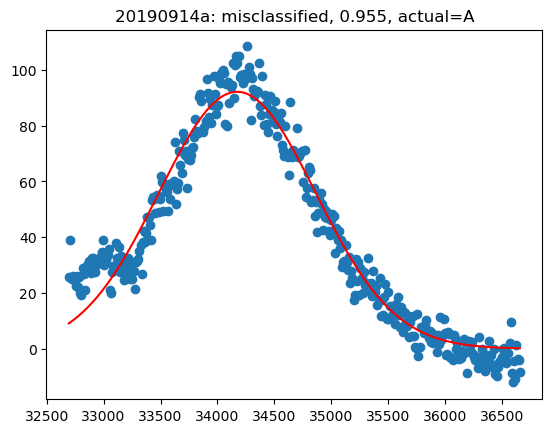

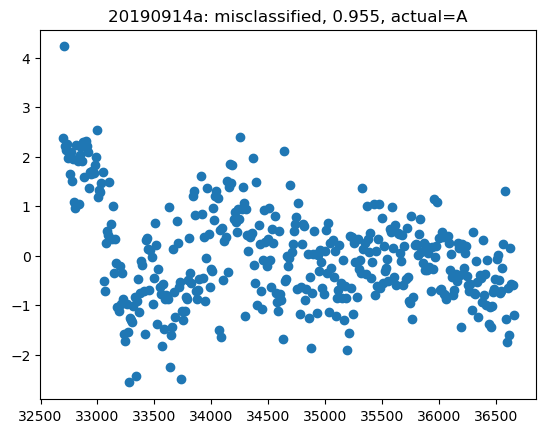

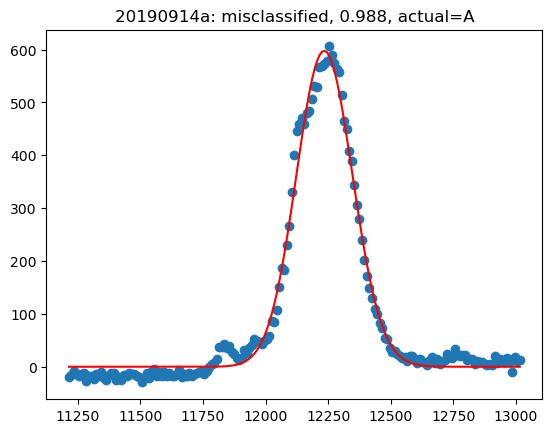

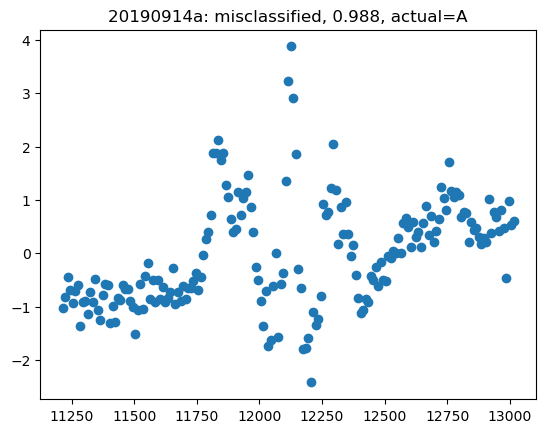

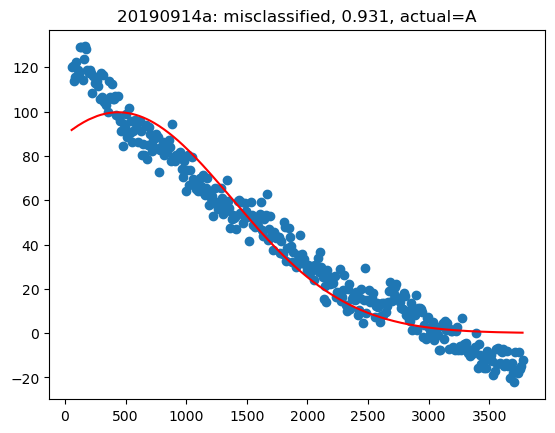

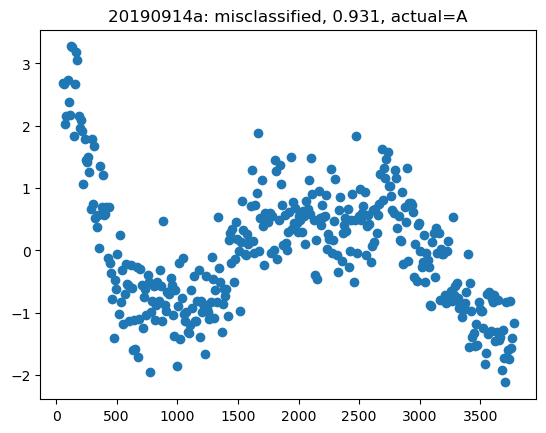

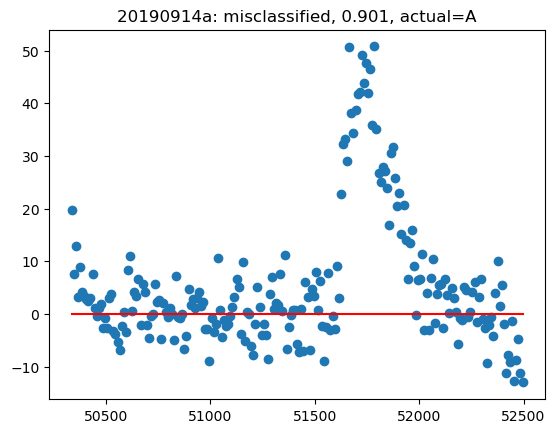

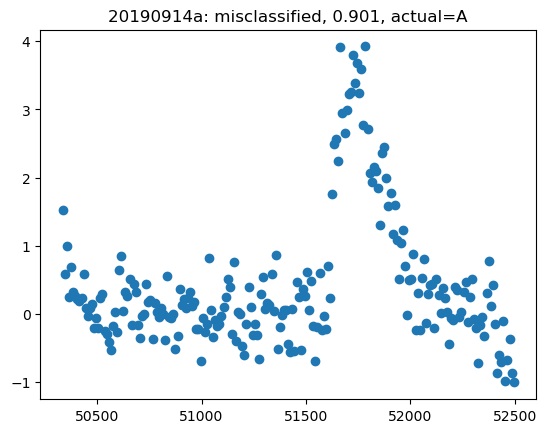

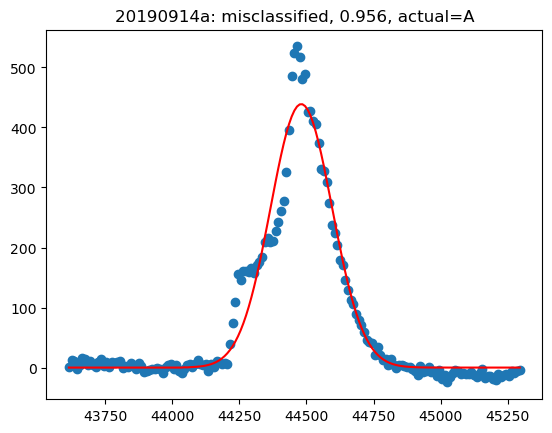

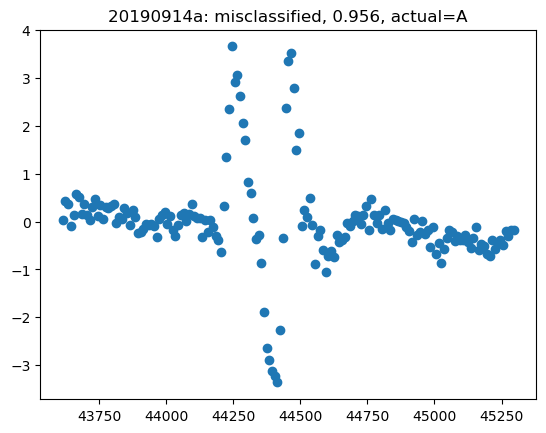

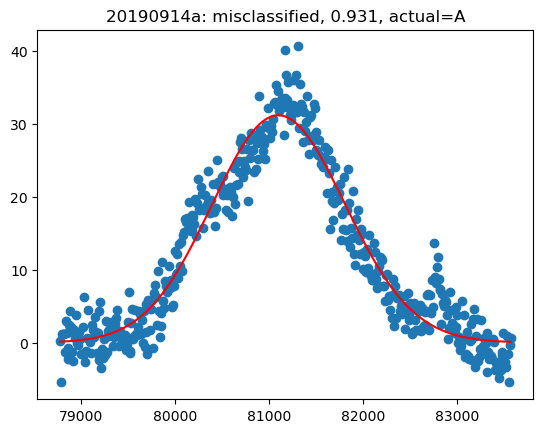

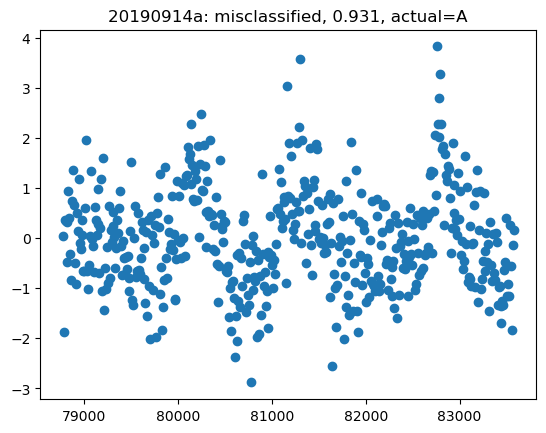

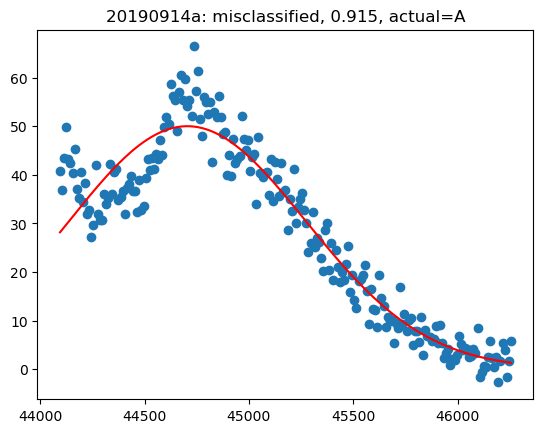

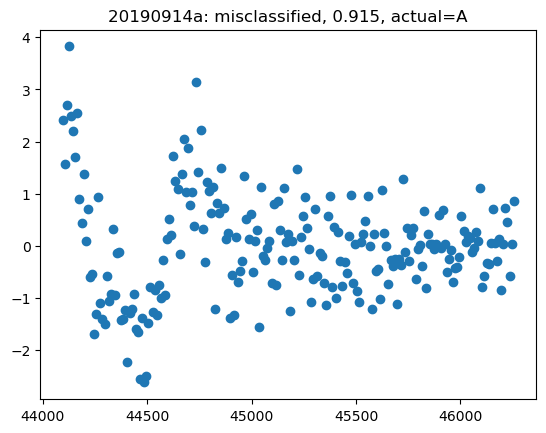

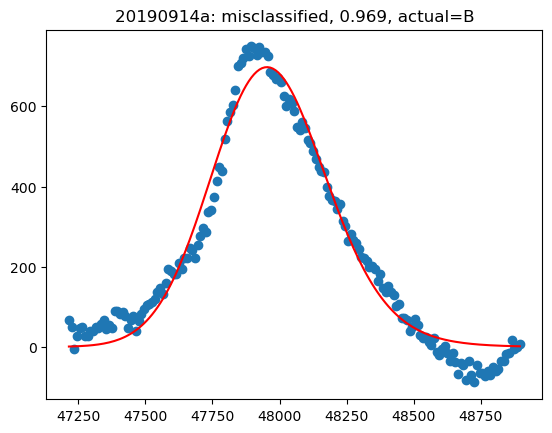

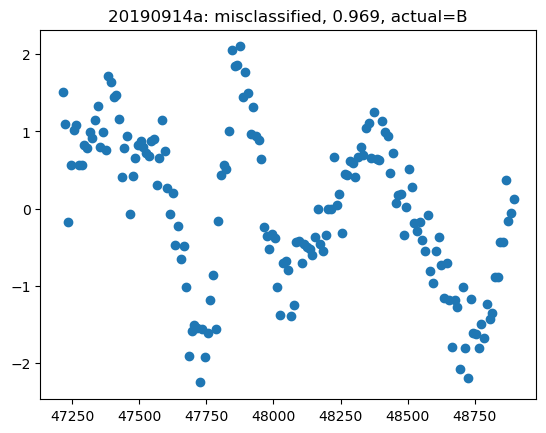

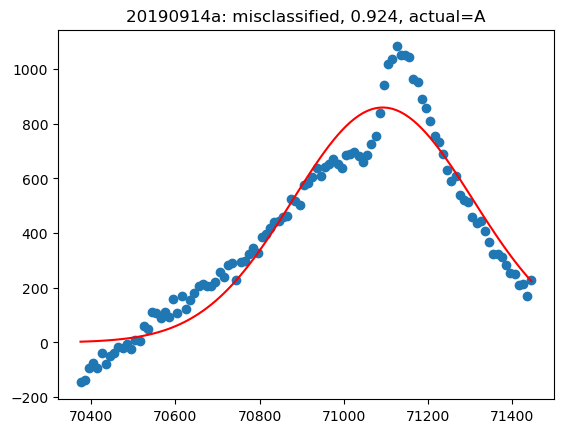

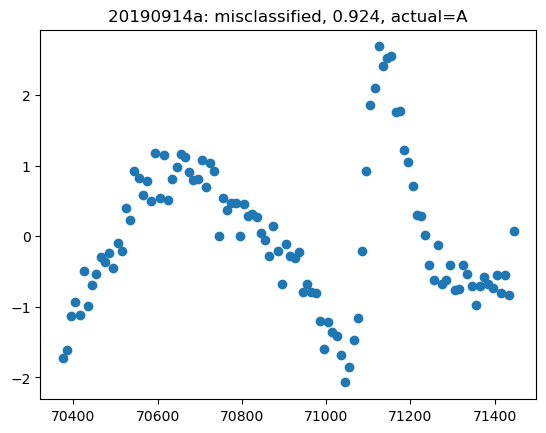

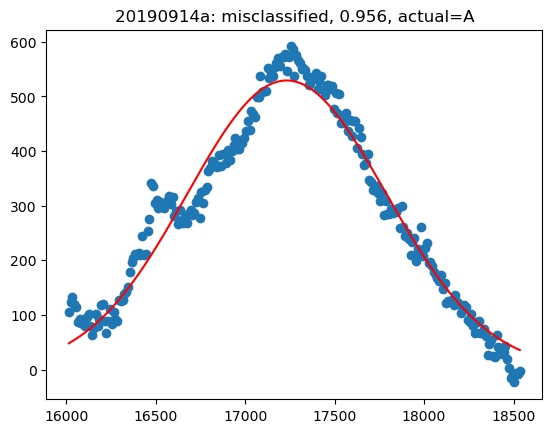

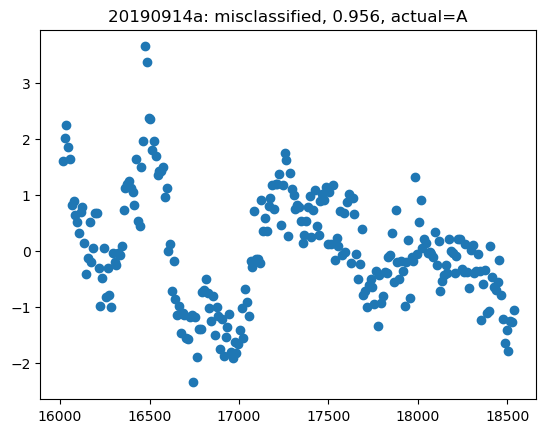

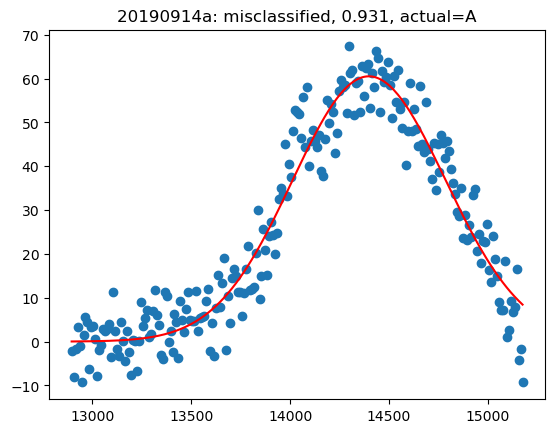

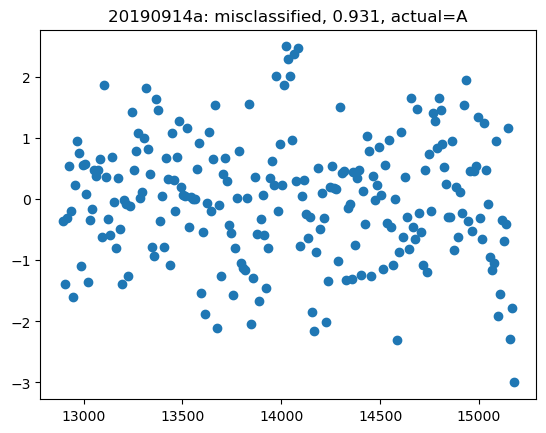

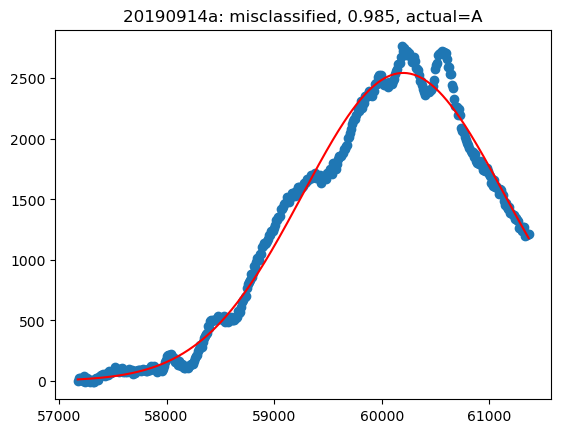

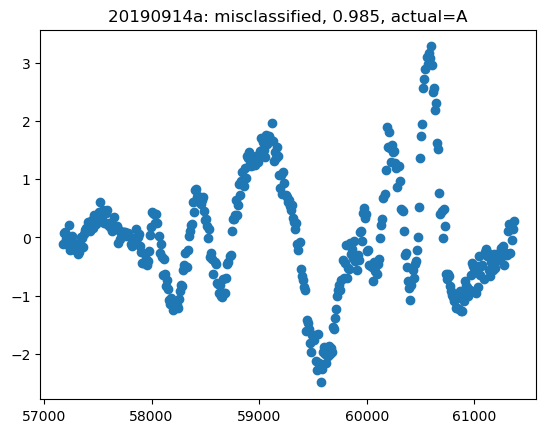

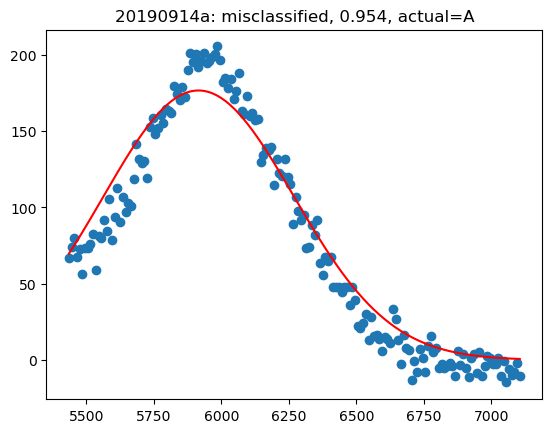

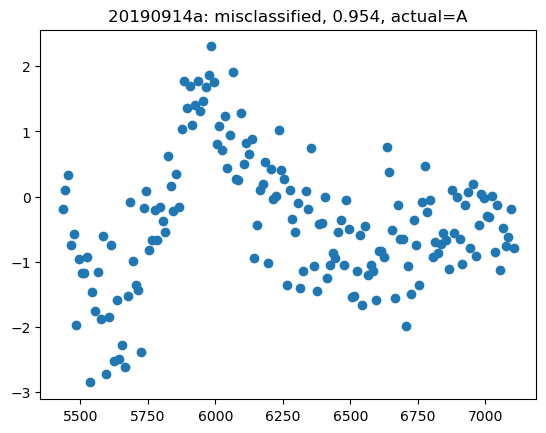

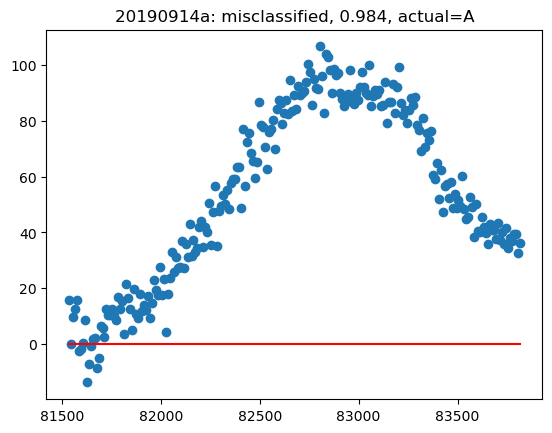

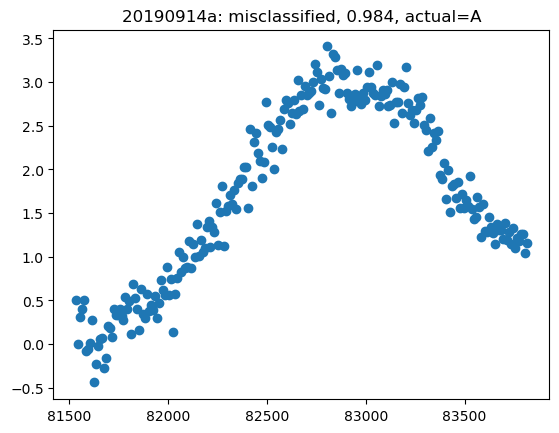

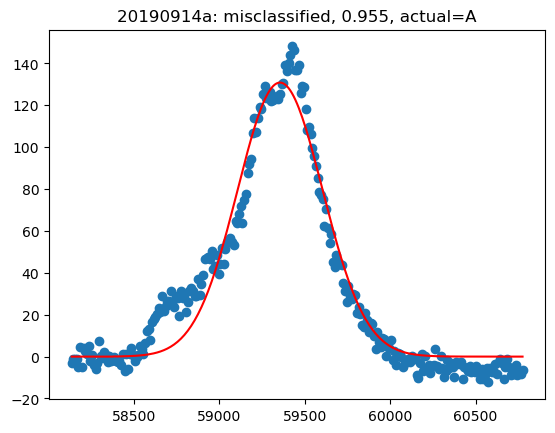

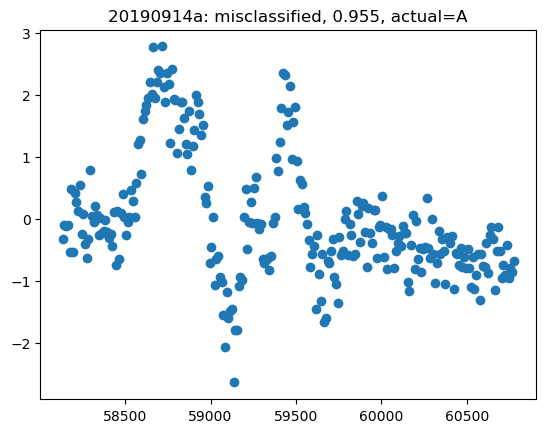

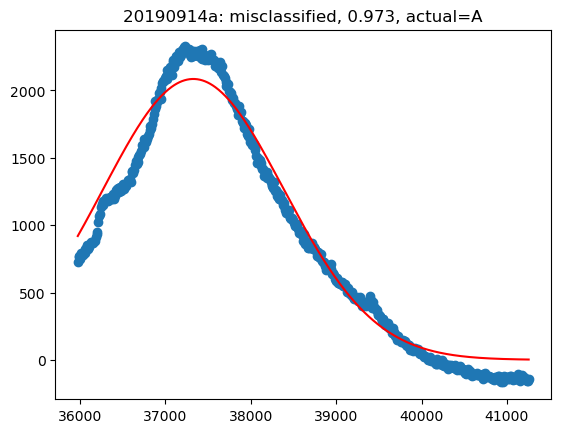

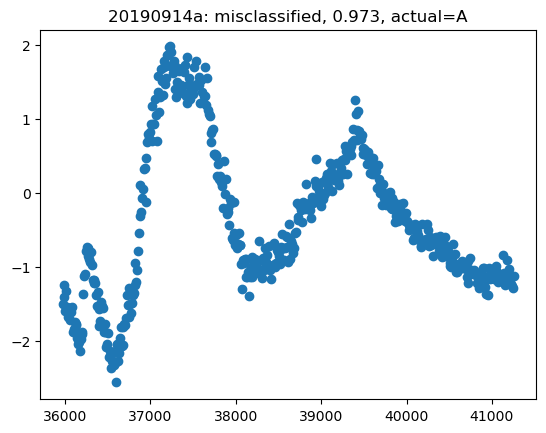

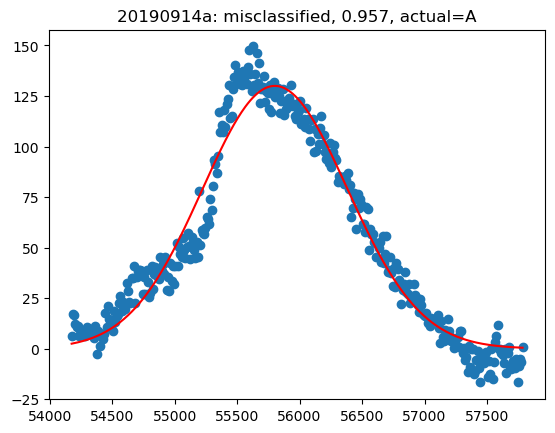

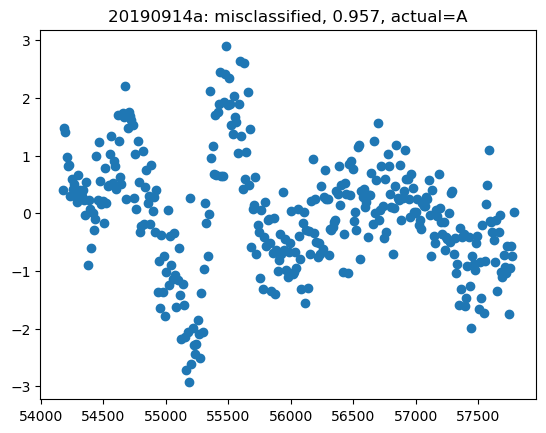

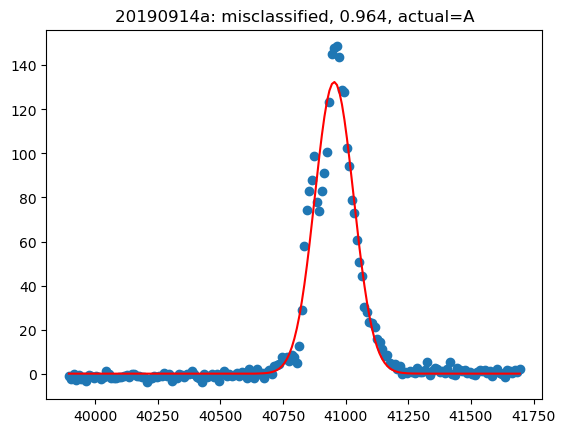

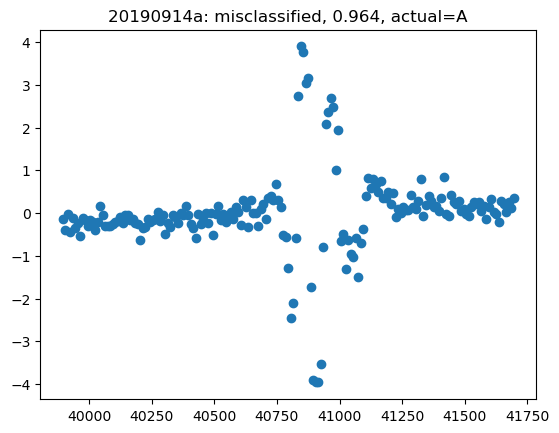

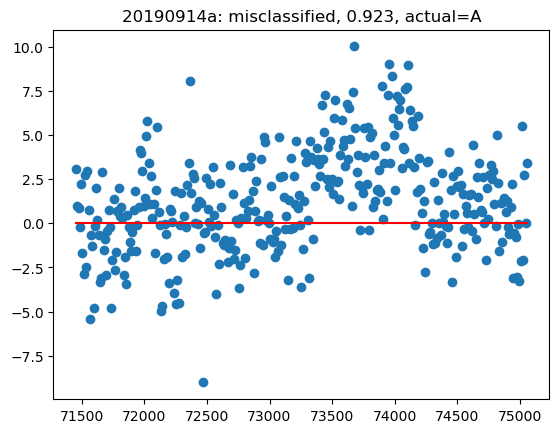

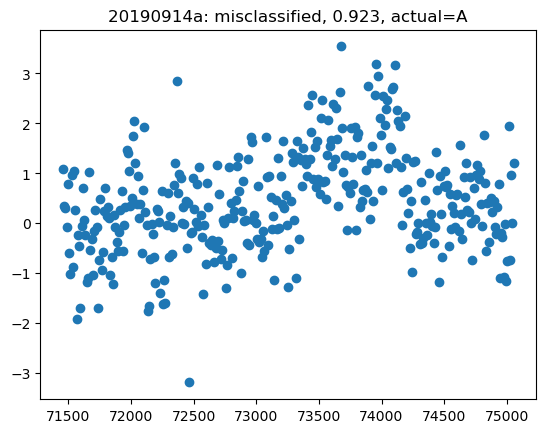

In [20]:
for id in bad:
    tod = pd.read_csv('flares/' + id + '.csv')
    
    yfit = EFP(tod['Time'], class_info['amplitude'][np.argwhere(class_info['identifier']==id)[0,0]], class_info['mu'][np.argwhere(class_info['identifier']==id)[0,0]], 
               class_info['sigma'][np.argwhere(class_info['identifier']==id)[0,0]], class_info['tau'][np.argwhere(class_info['identifier']==id)[0,0]])
        
    plt.scatter(tod['Time'], tod['Counts'])
    plt.plot(tod['Time'], yfit, c='r') 

    plt.title(iden + ': misclassified, ' + str(class_info['rsquared'][np.argwhere(class_info['identifier']==id)[0,0]]) + ', actual=' + class_info['flare_type'][np.argwhere(class_info['identifier']==id)[0,0]])

    plt.savefig(f'problem_flares/{id}.png')
    
    plt.show()
    
    plt.scatter(tod['Time'], (tod['Counts']-yfit)/np.std(tod['Counts']-yfit))

    plt.title(iden + ': misclassified, ' + str(class_info['rsquared'][np.argwhere(class_info['identifier']==id)[0,0]]) + ', actual=' + class_info['flare_type'][np.argwhere(class_info['identifier']==id)[0,0]])

    plt.show()